In [1]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

import imageio
import os
import random

from Combined_Agent_Double.Dueling_DDQN_Agent import Dueling_DDQN_Agent
from Combined_Agent_Double.utils.random_agent import RandomAgent
from Combined_Agent_Double.utils.actions import MORE_ACTIONS
import Combined_Agent_Double.utils.stats_functions as sf

import hockey.hockey_env as h_env

from importlib import reload

In [2]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291 + i for i in range(10)]

seed = SEED_TRAIN_1

USE_MORE_ACTIONS = True

In [3]:
reload(h_env)
env_name = "more_actions_test_2_150k_30k_(256_256)_nstep_5"
env = h_env.HockeyEnv()
h_env.HockeyEnv().seed(seed)

state_space = env.observation_space

if(USE_MORE_ACTIONS):
    action_space = spaces.Discrete(len(MORE_ACTIONS))
else: 
    action_space = env.discrete_action_space

agent = Dueling_DDQN_Agent(state_space, action_space, seed = seed, use_eps_decay = True, hidden_sizes = [256,256])
#opponent = RandomAgent(seed)
opponent = h_env.BasicOpponent()
agent.Q.load(env_name, "episode_90000")
stats, losses = sf.load_stats(env_name)

/home/pablosbl/Documents/GitHub/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/pablosbl/Documents/GitHub/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Dueling DQN Network Architecture:
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Dueling DQN Network Architecture:
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Network loaded from more_actions_test_2_150k_30k_(256_256)_nstep_5/weights/episode_90000.pth


/home/pablosbl/Documents/GitHub/hockey-en-mallorca/src/hockey-env/Combined_Agent_Double/QFunction.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(t

Plot saved at more_actions_test_2_150k_30k_(256_256)_nstep_5/stats/plots/returns_plot.png


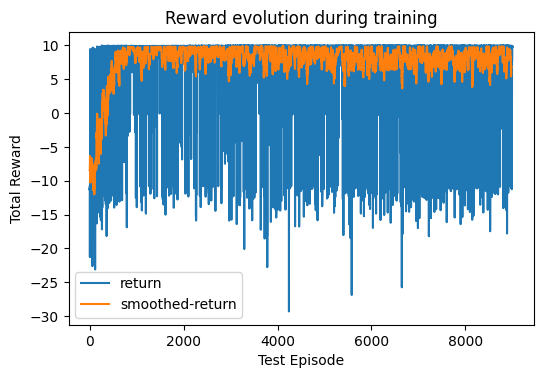

In [4]:
sf.plot_returns(stats, env_name)

Plot saved at more_actions_test_2_150k_30k_(256_256)_nstep_5/stats/plots/losses_plot.png


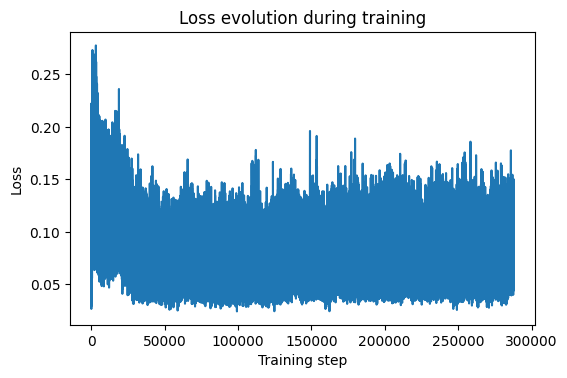

In [5]:
sf.plot_losses(losses, env_name)

Plot saved at more_actions_test_2_150k_30k_(256_256)_nstep_5/stats/plots/beta_evolution.png


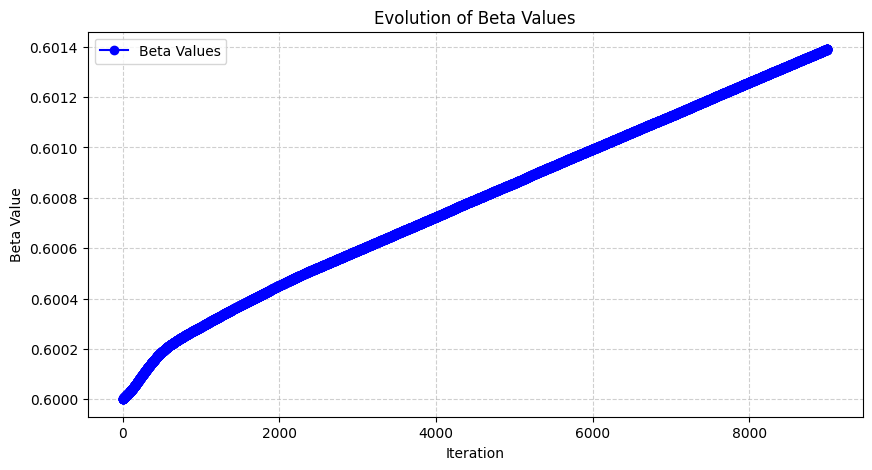

In [6]:
betas = sf.load_betas(env_name)
sf.plot_beta_evolution(env_name, betas)

Plot saved at more_actions_test_2_150k_30k_(256_256)_nstep_5/stats/plots/epsilon_evolution.png


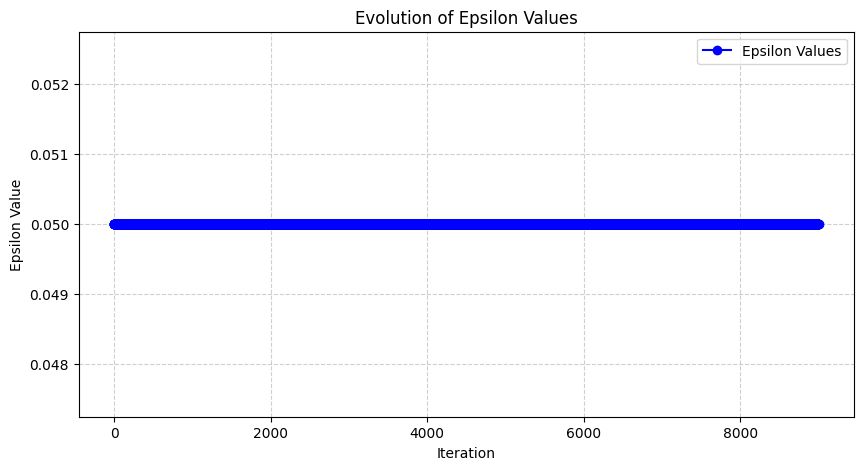

In [7]:
epsilons = sf.load_epsilons(env_name)
sf.plot_epsilon_evolution(env_name, epsilons)

Test Episode 1, Total Reward: -11.179557156049643
Test Episode 2, Total Reward: 9.501854939858152
Test Episode 3, Total Reward: -12.280788558589196
Test Episode 4, Total Reward: 9.545353731086347
Test Episode 5, Total Reward: -12.743701377945257
Test Episode 6, Total Reward: 9.510198968723513
Test Episode 7, Total Reward: 6.872479236812961
Test Episode 8, Total Reward: 9.39130822092671
Test Episode 9, Total Reward: -11.887588801334307
Test Episode 10, Total Reward: 9.447305720815411
Plot saved at more_actions_test_2_150k_30k_(256_256)_nstep_5/stats/plots/test_results.png


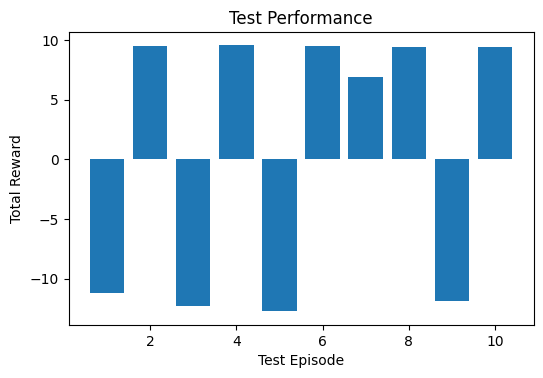

In [9]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = h_env.BasicOpponent(weak=False)

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        #a1 = env.discrete_to_continous_action(agent.perform_greedy_action(state))
        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs_2/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards)